# Week 3 - Linear Models and Efficient Computation with Kernels

## 🎯 Learning goals
1. Learn how to perform brain decoding using functional Magnetic Images (fMRI) data. For information about fMRI check: https://en.wikipedia.org/wiki/Functional_magnetic_resonance_imaging
2. Understand how kernel functions that compute inner products between feature vectors i.e. between pairs of data points enable efficient computation
2. Apply precomputed kernels using sklearn to solve a practical problems when the number of features is higher than the sample size (e.g. medical imaging)
3. Understand when to use precomputed kernels and how it relates to the primal and dual formulations

### Most common use case of Kernels
Kernels can help machine learning models learn nonlinear decision boundaries by mapping input data into a higher dimensional feature space. This allows algorithms like support vector machines (SVMs) to find nonlinear boundaries in the input space to classify data. However, using kernels can be also a computational efficient way to train kernel models (e.g. SVMs) when the number of features is higher than the sample size.
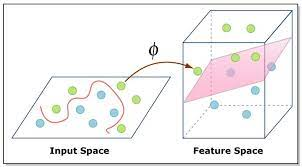

## 📍 0. Setting up context: Haxby fMRI dataset

- The Haxby study investigated face and object representation in human ventral temporal cortex
- The study consisted of 6 subjects passively viewing greyscale images of eight object categories (eg houses, cats, faces), grouped in 24s blocks separated by rest periods
- The study showed the images for 500ms and was followed by a 1500ms inter-stimulus interval, whilst taking a full-brain fMRI.
- More information can be found in the original study: Haxby, J., Gobbini, M., Furey, M., Ishai, A., Schouten, J., and Pietrini, P. (2001). Distributed and overlapping representations of faces and objects in ventral temporal cortex. Science 293, 2425–2430: https://www.science.org/doi/10.1126/science.1063736

### 0.1 Downloading dataset

We will use `nilearn` a python wrapper around `scikit-learn` that provides useful visualisation and statistical, ML tools for brain volume analysis.

The `nilearn.datasets.fetch_haxby` function will download the Haxby dataset if not present on the disk, in the nilearn data directory. It can take a while to download about 310 MB of data from the Internet.

In [ ]:
! pip install nilearn

In [ ]:
from nilearn import datasets

# By default 2nd subject will be fetched
haxby_dataset = datasets.fetch_haxby()
# 'func' is a list of filenames: one for each subject
fmri_filename = haxby_dataset.func[0]

# print basic information on the dataset
print(f"First subject functional nifti images (4D) are at: {fmri_filename}")


### 0.2 Visualizing the fMRI volume

One way to visualize a fMRI volume is using `nilearn.plotting.plot_epi.` We will visualize the previously fetched fMRI data from Haxby dataset.

Because fMRI data are 4D (they consist of many 3D EPI images), we cannot plot them directly using nilearn.plotting.plot_epi (which accepts just 3D input). Here we are using `nilearn.image.mean_img` to extract a single 3D EPI image from the fMRI data.

In [ ]:
from nilearn import plotting
from nilearn.image import mean_img

print(f'mean_image dimensionality {mean_img(fmri_filename).shape}')

plotting.view_img(mean_img(fmri_filename), threshold=None)




### 0.3 Loading the mask

These are some really lovely images, but for machine learning we need matrices to work with the actual data. If we want to use sklearn we will need to transform the Nifti images into a data matrix. For the first model we will only use voxels within Ventral Temporal (VT) cortex which is an visual processing area. A mask of the VT cortex coming from the Haxby study is available. We have to define a mask filename.

In [ ]:
mask_filename = haxby_dataset.mask_vt[0]

# Let's visualize it, using the subject's anatomical image as a
# background
plotting.plot_roi(mask_filename, bg_img=haxby_dataset.anat[0], cmap="Paired")

print(mask_filename)

### 0.4 Loading the behavioral labels

Now we can load the behavioral labels that are stored in a CSV file, separated by spaces.

We use pandas to load them in an array.


The task was a visual-recognition task, and the labels denote the experimental condition: the type of object that was presented to the subject. This is what we are going to try to predict.

In [ ]:
import pandas as pd

# Load behavioral information
behavioral = pd.read_csv(haxby_dataset.session_target[0], delimiter=" ")

# Enable viewing of all rows of pandas dataframe
pd.set_option('display.max_rows', None)
print(behavioral)

As we can see from the targets above, the experiment contains many conditions. As a consequence, the data is quite big. Not all of this data has an interest to us for decoding, so we will keep only fMRI signals corresponding to faces or houses. We create a mask of the samples belonging to the condition; this mask is then applied to the fMRI data to restrict the classification to the face vs house discrimination.

The input data will become much smaller (i.e. fMRI signal is shorter):

In [ ]:
from nilearn.image import index_img, smooth_img
import numpy as np

condition_mask = behavioral["labels"].isin(["face", "house"])
# The data is in one single large 4D image
fmri_niimgs = index_img(fmri_filename, condition_mask)

# Reading mask Nifti from filename path
fmri_niimgs_mask = smooth_img(mask_filename, None)


# Checking dimensionality of data
print(f'4D data dimensionality {fmri_niimgs.shape}')
print(f'mask dimensionality {fmri_niimgs_mask.shape}')


### 0.5 Converting the images into a data matrix and applying the mask

Reshape the Data

In [ ]:
# Convert the NIfTI image to a numpy array
data = fmri_niimgs.get_fdata()

# Reshape the data
# -1 will automatically calculate the size of the first dimension
reshaped_data = data.reshape(-1, data.shape[-1])

print(reshaped_data.shape)

Reshape Mask

In [ ]:
data_mask = fmri_niimgs_mask.get_fdata()
reshaped_mask = data_mask.reshape(-1)

print(reshaped_mask.shape)

Count non-zero elements in the mask

In [ ]:
print(reshaped_mask.sum())

Try reshaping the reshaped data and mask to the original shape

In [ ]:
# reshaping to original

original_data_shape = (40, 64, 64, 216)  # Replace with the actual original shape
original_mask_shape = (40, 64, 64)

# Reshape data back to the original shape
data_original_shape = reshaped_data.reshape(original_data_shape)

# Reshape mask back to the original shape
mask_original_shape = reshaped_mask.reshape(original_mask_shape)

Check if the un-reshaped data and mask match the original

In [ ]:
# check if original and un-reshape reshaped match
print(np.array_equal(data, data_original_shape))

# check if original and un-reshape reshaped match
print(np.array_equal(data_mask, mask_original_shape))

Now for the reshaped data, filter it to only include corresponding elements from the mask which are non-zero. Also create a matrix which lists the element position of the non-zero elements from the mask

In [ ]:
# Apply the mask to the data
filtered_data = reshaped_data[reshaped_mask != 0]

# To get the index positions of the non-zero elements in the mask
# np.nonzero returns a tuple - take the first element
nonzero_indices = np.nonzero(reshaped_mask)[0]

# Now, 'filtered_data' contains only the rows with non-zero mask elements
# and 'nonzero_indices' contains the indices of these non-zero elements

# If you need an index matrix with the same shape as the filtered_matrix
# where each row is filled with the corresponding index from nonzero_indices
index_matrix = np.tile(nonzero_indices[:, np.newaxis], (1, filtered_data.shape[1]))

print(filtered_data.shape)
print(nonzero_indices)

We apply the same mask that we applied to the fMRI data to the targets

In [ ]:
conditions = behavioral["labels"][condition_mask]
# Convert to numpy array
conditions = conditions.values
print(conditions.shape)
print(conditions)

We need to create a vector of binary labels y

In [ ]:
# add code to convert conditions to binary labels y

# Convert 'face' to 1 and 'house' to 0
y = np.where(conditions == 'face', 1, 0)

In [ ]:
print(filtered_data.shape)
print(y.shape)

In [ ]:
# The number of features is the first dimension of filtered_data, and the number of samples is the second dimension
num_samples = filtered_data.shape[1]

# Calculate the index to split the dataset
split_index = num_samples - 30  # Reserve the last 30 samples for testing

# Split the data along the second dimension
X_train, X_test = filtered_data[:, :split_index], filtered_data[:, split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Confirm the dimensions
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)



# 🧑‍💻 TASK 1: Train an SVM to decode the labels from the fMRI data


## 1.1 split the `filtered_data` into train and test (leaving the last 30 examples for test)

In [ ]:
# The number of features is the first dimension of filtered_data, and the number of samples is the second dimension
num_samples = filtered_data.shape[1]

# Calculate the index to split the dataset
split_index = None  # Reserve the last 30 samples for testing

# Split the data along the second dimension
X_train, X_test = filtered_data[:, :split_index], filtered_data[:, split_index:]
y_train, y_test = y[None], y[None]

# Transpose X_train and X_test so that each row represents a sample
X_train = X_train.None
X_test = X_test.None

# Confirm the dimensions
print("X_train shape:", X_train.None)
print("y_train shape:", y_train.None)
print("X_test shape:", X_test.None)
print("y_test shape:", y_test.None)

## 1.2 do a **cross-validation** on the training set to optimize the SVM hyper-parameters + print the mean and the standard deviation of the CV score, the best hyperparameter and the test score

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import time

param_grid = {
    'C': [None],  # Example values
    'gamma': [None],
    'kernel': ['rbf', 'linear']
}

# Create a GridSearchCV object with an SVM classifier
grid = GridSearchCV(None)  # 5-fold cross-validation

# Time the grid search
start_time = time.time()

# Perform grid search
grid.None

# Measure and print the time taken
time_taken = time.time() - start_time
print("Time taken for GridSearchCV with regular kernels: {:.2f} seconds".format(time_taken))


# Print the results
print("Mean CV Score: ", grid.cv_results_['mean_test_score'][grid.best_index_])
print("Std Dev of CV Score: ", grid.cv_results_['std_test_score'][grid.best_index_])
print("Best Hyperparameters: ", grid.best_params_)

# Evaluate on the test set
y_pred = grid.None
test_score = accuracy_score(None)
print("Test Score: ", test_score)


# Predict on the test set
y_pred = grid.None

# Print predictions
print("Predictions on the test set:", y_pred)

# Calculate and print the accuracy score
test_accuracy = accuracy_score(None)
print("Final Test Accuracy:", test_accuracy)

## 1.3 inspect the SVM weights

Now let's inspect and display the SVC model' weights by turning them into a nifti image.

First we want to retrieve the SVM weights.

In [ ]:
# add the code here to show the coefficients

# Make sure your best model is using a linear kernel
print("kernel:", grid.best_params_['kernel'])

# If the kernel is linear, retrieve the weights
if grid.None == 'linear':
    # The best estimator in your grid search
    best_svm = grid.None

    # Retrieve the SVM weights (coefficients)
    svm_weights = best_svm.None

    # Print the weights
    print("SVM Weights:", svm_weights)
else:
    print("SVM weights are not interpretable for non-linear kernels.")


It’s an array with only one coefficient per voxel.

In [ ]:
# add code to print the coef. shape
print("Shape of SVM Coefficients:", svm_weights.shape)

To get the Nifti image of these coefficients we need to convert the coef. to 3D and create a Nifti image

In [ ]:
print(type(data_mask))

In [ ]:
# add code here

from nilearn.image import new_img_like

# Initialize a 3D array with zeros
# Assume original_shape is the shape of the original 3D brain image
coef_3d = coef_3d = np.None

# Map the coefficients back to their original voxel locations
coef_3d.flat[nonzero_indices] = svm_weights

print(coef_3d.shape)


# Create a Nifti image
coef_img = new_img_like(fmri_niimgs_mask, coef_3d)

# coef_img is now a Nifti image of the SVM coefficients

## 1.4 plotting the SVM weights
We can plot the weights, using the subject’s anatomical as a background

In [ ]:
# add code here
from nilearn import plotting

# Assuming coef_img is the Nifti image containing your SVM weights
# and haxby_dataset.anat[0] is the path to the anatomical image

# Plot the SVM weights
plotting.plot_stat_map(coef_img, bg_img=haxby_dataset.anat[0],
                       display_mode='ortho',
                       title='SVM Weights',
                       cut_coords=(28, -34, -22),
                       cmap='coolwarm')

# Show the plot
plotting.show()


# 👩‍💻 TASK 2: Train an SVM with pre-computed kernel for computational efficiency

For the second task we will use the whole brain voxels as features. We will start by creating a whole brain mask to include all voxels within the brain





In [ ]:
from nilearn.maskers import NiftiMasker
from nilearn.plotting import plot_epi, plot_roi, show

masker = NiftiMasker(mask_strategy="epi")
masker.fit(fmri_filename)
#report = masker.generate_report()
#report

whole_brain_mask = masker.mask_img_

# Let's visualize the whole brain mask, using the subject's anatomical image as a
# background
plotting.plot_roi(whole_brain_mask, bg_img=haxby_dataset.anat[0], cmap="Paired")

# Checking dimensionality of the mask
print(f'Mask dimensionality {whole_brain_mask.shape}')

Reshape whole brain mask


In [ ]:
# Convert the NIfTI image to a numpy array
wb_mask = whole_brain_mask.get_fdata()
reshaped_wb_mask = wb_mask.reshape(None)

# Reshape the data
print(reshaped_wb_mask.shape)

# print(reshaped_whole_brain_mask.shape)

Count non-zero elements in the new mask, which corresponds to the number of voxels within the whole brain mask

In [ ]:
print(reshaped_wb_mask.None)

In [ ]:
# Apply the whole mask to the data
filtered_wb_data = reshaped_data[None]

# To get the index positions of the non-zero elements in the mask
# np.nonzero returns a tuple - take the first element
nonzero_wb_indices = np.None

# Now, 'filtered_data' contains only the rows with non-zero mask elements
# and 'nonzero_indices' contains the indices of these non-zero elements

# If you need an index matrix with the same shape as the filtered_matrix
# where each row is filled with the corresponding index from nonzero_indices
index_wb_matrix = np.tile(nonzero_indices[:, np.newaxis], (1, filtered_wb_data.shape[1]))

print(filtered_wb_data.shape)

Now we can create a data matrix using the whole brain mask and compute linear kernel from the data matrix $K = X'X$, and will repeat task 1 training the SVM using the option of a pre-computed kernel.

https://scikit-learn.org/stable/auto_examples/svm/plot_custom_kernel.html#sphx-glr-auto-examples-svm-plot-custom-kernel-py

## 2.1 Set up test/train split like in task 1

In [ ]:
# add code here

# The number of features is the first dimension of filtered_data, and the number of samples is the second dimension
num_samples = filtered_wb_data.shape[1]

# Calculate the index to split the dataset
split_index = num_samples - 30  # Reserve the last 30 samples for testing

# Split the data along the second dimension
X_train, X_test = filtered_wb_data[:, :split_index], filtered_wb_data[:, split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Transpose X_train and X_test so that each row represents a sample
X_train = None
X_test = None

# Confirm the dimensions
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

In [ ]:
def linear_kernel(X,Y):
#     print(X.shape,Y.shape)
#     M = np.array([[2, 0], [0, 1.0]])
    return None

X_train_kernel = linear_kernel(None)
X_test_kernel = linear_kernel(None)

# Check the kernel and the data dimensionality
print("X_train_kernel shape:", X_train_kernel.shape)
print("X_train shape:", X_train.shape)
print("X_test_kernel shape:", X_test_kernel.shape)
print("X_test shape:", X_test.shape)

## 2.3 Train SVM with precomputed Kernel on the entire original dataset ie `reshaped_data` rather than the masked reduced features dataset ie `filtered_data`


🤔 What can we learn from the time differences of GridSearchCV using regular Kernels (task 1) vs a precomputed Kernel (task 2)?

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import time

# Define the parameter grid for hyperparameter tuning
param_grid_precomputed = {
    'C': [0.1, 1, 10, 100],  # Example values
    #    'gamma': [1, 0.1, 0.01, 0.001], # Do we need gamma? No since it's hyperparameter for certain kernel function like RBF
     'kernel': ['precomputed']
}

# Create a GridSearchCV object for the precomputed kernel
grid_precomputed = GridSearchCV(SVC(), param_grid_precomputed, refit=True, verbose=2, cv=5)

# Time the grid search for the precomputed kernel
start_time_precomputed = time.time()

# Perform grid search
grid_precomputed.None

# Measure and print the time taken
time_taken_precomputed = time.time() - start_time_precomputed
print("Time taken for GridSearchCV with precomputed kernel: {:.2f} seconds".format(time_taken_precomputed))


# Print the results
print("Mean CV Score: ", grid_precomputed.cv_results_['mean_test_score'][grid.best_index_])
print("Std Dev of CV Score: ", grid_precomputed.cv_results_['std_test_score'][grid.best_index_])
print("Best Hyperparameters: ", grid_precomputed.best_params_)

# Evaluate on the test set

y_pred = grid_precomputed.predict(X_test_kernel)
test_score = accuracy_score(y_test, y_pred)
print("Test Score: ", test_score)




# Mapping the dual weights back to the primal

In order to visualize the weights in the input space we need to map the SVM dual coefficients back to the primal weights

In [ ]:
# Add code here
#
best_svm = grid_precomputed.None

    # Retrieve the SVM weights (coefficients)
support_index = best_svm.support_
svm_alpha = best_svm.None

In [ ]:
precomputed_svm_weight = np.zeros(X_train.shape[1])
for i in range(len(support_index)):
    precomputed_svm_weight += X_train[support_index[i]]*svm_alpha[0][i]

In [ ]:
precomputed_svm_weight.shape

Once we have the primal weights we can now create a nifti image using the same procedure as before

In [ ]:
# Add code here

from nilearn.image import new_img_like

# Initialize a 3D array with zeros
# Assume original_shape is the shape of the original 3D brain image
coef_3d = coef_3d = np.None

# Map the coefficients back to their original voxel locations
coef_3d.flat[None] = precomputed_svm_weight

# print(coef_3d.shape)


# Create a Nifti image
coef_img = new_img_like(fmri_niimgs_mask, coef_3d)

# coef_img is now a Nifti image of the SVM coefficients

In [ ]:
# add code here
from nilearn import plotting

# Assuming coef_img is the Nifti image containing your SVM weights
# and haxby_dataset.anat[0] is the path to the anatomical image

# Plot the SVM weights
plotting.plot_stat_map(coef_img, bg_img=haxby_dataset.anat[0],
                       display_mode='ortho',
                       title='SVM Weights',
                       cut_coords=(28, -34, -22),
                       cmap='coolwarm')

# Show the plot
plotting.show()
